
# Diffusion Model Homework Notebook

In this notebook, you will work with a diffusion model on a generated Swiss Roll dataset. Our overall goals are to:
- Understand how to embed time in a neural network.
- Calculate the diffusion (forward) and reverse processes.
- Compute the loss based on the discrepancy between predicted noise and the true noise.

> **Key Learning Objectives:**
> 1. **Loss Computation (Theory & Code):**  
>    Understand and implement the loss:  
$$
      \mathcal{L} = \frac{1}{N}\sum_{i=1}^{N} \left\Vert \hat{\epsilon}_i - \epsilon_i \right\Vert^2
$$
>    where $\hat{\epsilon}$ is the noise predicted by the model, and $\epsilon$ is the actual noise added in the forward process.
>
> 2. **Noise Scheduling and Reverse Process:**  
>    Understand the roles of the beta schedule and the computation of the reverse process steps.
>
> 3. **Practical Implementation:**  
>   Write and debug the parts of the code where you fill in the redacted parts based on the mathematical formulas.

Let's get started with the necessary imports and setting of random seeds.


In [1]:
# Imports and random seed setup

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Set random seed for reproducibility
torch.manual_seed(42)  # Ensures that the PyTorch random generators are deterministic
np.random.seed(42)     # Ensures that the NumPy random generators are deterministic

## Swiss Roll Data Generation
The following cell contains a function to generate a 2D Swiss Roll, which will be our training dataset.

In [2]:
def generate_swiss_roll(n_samples=1000):
    """
    Generate 2D Swiss Roll data points.

    Args:
        n_samples: Number of points to generate.

    Returns:
        torch.Tensor of shape (n_samples, 2)
    """
    # Generate random angles for the spirals
    t = 1.5 * np.pi * (1 + 2 * torch.rand(n_samples))  # Random parameter t
    # Compute x and y using cosine and sine
    x = t * torch.cos(t)  # x-coordinate of the Swiss roll
    y = t * torch.sin(t)  # y-coordinate of the Swiss roll

    # Stack x and y together and scale the data to approximately fit within [-1, 1]
    data = torch.stack([x, y], dim=1) / 15.0
    return data

# Example call
sample_data = generate_swiss_roll()
print(sample_data.shape)

torch.Size([1000, 2])


## Defining the Time Embedding Module

The next module embeds a scalar time-step into a higher dimensional space.


In [3]:
class TimeEmbedding(nn.Module):
    """Time embedding layer converts a scalar time input into a higher dimensional embedding."""
    def __init__(self, dim):
        super().__init__()
        # Define a simple MLP with two linear transformations and a GELU activation.
        self.embed = nn.Sequential(
            nn.Linear(1, dim),  # First linear layer
            nn.GELU(),          # GELU activation for non-linearity
            nn.Linear(dim, dim) # Second linear layer
        )

    def forward(self, t):
        # Ensure the time tensor has a feature dimension.
        t = t.unsqueeze(-1).float()  # Reshape to (batch_size, 1)
        return self.embed(t)  # Return the time embedding

## Diffusion Model Architecture

This cell defines the MLP-based diffusion model. It uses the time embedding and includes residual connections and scaling.


In [4]:
class DiffusionModel(nn.Module):
    """MLP-based diffusion model with time embedding for Swiss Roll data."""
    def __init__(self, hidden_dim=128):
        super().__init__()

        # Time embedding module to incorporate time information into the model.
        self.time_embed = TimeEmbedding(hidden_dim)

        # Initial input layer transforms 2D data to the hidden dimension.
        self.input_layer = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.GELU()
        )

        # Hidden layers with added time embedding at each step and residual connections.
        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.GELU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.GELU()
            ) for _ in range(3)
        ])

        # Final output layer brings the features back to 2D.
        self.output_layer = nn.Linear(hidden_dim, 2)

    def forward(self, x, t):
        # Compute the time embedding from the given time input.
        t_emb = self.time_embed(t)

        # Process input data through the first layer.
        h = self.input_layer(x)
        # Add the time embedding to the layer activation.
        h = h + t_emb

        # Loop over each hidden layer:
        for layer in self.hidden_layers:
            h_prev = h  # Save current h for residual connection.
            h = layer(h)  # Process with current hidden layer.
            h = h + h_prev  # Residual connection.
            h = h + t_emb   # Add time embedding at each hidden layer.
            h = h / math.sqrt(2)  # Normalize the activation.

        # Final output transformation to reconstruct the 2D output.
        x = self.output_layer(h)
        return x

## Diffusion Scheduler and Reverse Process

This cell defines the noise scheduler responsible for scheduling beta parameters over timesteps. It
also includes methods for the forward (diffuse) and reverse (denosing) processes.

**Note:** The reverse process relies on a core computation matching the theoretical formula for denoising.  
For the reverse step, the formula is given as:

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \hat{\epsilon} \right)
+ \sqrt{\beta_t} \cdot \mathbf{z}
$$

where:
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{s=0}^{t} \alpha_s$
- $\hat{\epsilon}$ is the predicted noise.
- $\mathbf{z}$ is standard Gaussian noise (only if $t > 0$).

The implementation in the code cell has a `TODO` where you need to implement this formula.

In [5]:
class DiffusionScheduler:
    """Scheduler that handles noise scheduling for the diffusion model."""
    def __init__(self, num_timesteps=1000, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device

        # Create an improved beta scheduling linearly spaced
        self.betas = torch.linspace(1e-4, 0.02, num_timesteps).to(device)  # Beta schedule
        self.alphas = 1. - self.betas  # Define alphas from betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)  # Cumulative product of alphas

        # Precompute square roots for speed
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # Reverse process parameters
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)

        # For posterior variance, compute alphas_cumprod for previous timestep (with a 1 at the start)
        alphas_cumprod_prev = torch.cat([torch.ones(1).to(device), self.alphas_cumprod[:-1]])
        self.posterior_variance = self.betas * (1. - alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def diffuse(self, x_0, t):
        """
        Forward diffusion: add noise to the data.

        Args:
            x_0: Original data.
            t: Time step indices.

        Returns:
            Noisy data x_t and the noise that was added.
        """
        noise = torch.randn_like(x_0)  # Generate Gaussian noise

        # Get scaling terms for the chosen timesteps
        sqrt_alpha_t = self.sqrt_alphas_cumprod[t].view(-1, 1)  # Scale for clean data
        sqrt_one_minus_alpha_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)  # Scale for noise

        # x_t according to the diffusion process equation
        x_t = sqrt_alpha_t * x_0 + sqrt_one_minus_alpha_t * noise
        return x_t, noise

    def reverse_step(self, x_t, t, predicted_noise):
        """
        Reverse process (denoising) for a single timestep.

        **Core Computation:**
        \[
        x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \hat{\epsilon} \right)
        + \sqrt{\beta_t} \cdot \mathbf{z}
        \]
        where \(\mathbf{z} \sim \mathcal{N}(0, I)\) if \(t > 0\), else \(\mathbf{z} = 0\).

        **TODO:** Implement the equation above.

        **Hint:**
        - Use `self.alphas[t]` for \(\alpha_t\).
        - Use `self.alphas_cumprod[t]` for \(\bar{\alpha}_t\).
        - For noise, use `torch.randn_like(x_t)` if `t > 0` else zero.
        """
        alpha = self.alphas[t]  # Get \alpha_t
        alpha_bar = self.alphas_cumprod[t]  # Get \bar{\alpha}_t
        beta_t = self.betas[t]

        # TODO: Implement the reverse step update based on the formula given in the markdown above.
        # For now, we leave this as a stub for the you to complete.
        # Expected steps:
        #   1. Compute the term: (x_t - coeff * predicted_noise)
        #   2. Scale the term by 1/sqrt(alpha)
        #   3. If t > 0, add noise scaled by sqrt(beta)

        if t > 0:
            noise = torch.randn_like(x_t)  # Noise term only if not the last timestep.
        else:
            noise = 0

        # ----- TODO Implementation Starts Here -----
        #
        # Compute the first term: 1/sqrt(alpha) * (x_t - (1 - alpha)/sqrt(1 - alpha_bar) * predicted_noise)
        # Then, add sqrt(beta_t) * noise
        #
        # Example (pseudocode):
        # coeff = (1 - alpha) / sqrt(1 - alpha_bar)
        # x_t_minus_1 = (1 / sqrt(alpha)) * (x_t - coeff * predicted_noise) + sqrt(betas[t]) * noise
        #
        coeff = (1 - alpha) / torch.sqrt(1 - alpha_bar)  # Calculate the coefficient
        x_t_minus_1 = (1 / torch.sqrt(alpha)) * (x_t - coeff * predicted_noise) + torch.sqrt(beta_t) * noise
        # ----- TODO Implementation Ends Here -----

        # ---- Placeholder value below ----
        # Remove the following line after implementing the code.
        # raise NotImplementedError("Reverse step function is not implemented. Please complete the TODO part based on the provided formula.")

        return x_t_minus_1  # Uncomment when implementation is complete.

## Training the Diffusion Model

In this cell, we define the training loop for our diffusion model.
One critical step is computing the MSE loss between the predicted noise and the true noise.
Recall that the loss is defined as:
$$
\mathcal{L} = \frac{1}{N}\sum_{i=1}^{N} \left\Vert \hat{\epsilon}_i - \epsilon_i \right\Vert^2
$$
The corresponding code line should match this formula.

For the training loop, some parts remain intact.  
Feel free to adjust the number of training steps or the learning rate as needed.

In [6]:
def train_diffusion(n_steps=10000, batch_size=128, lr=1e-3):
    """Train the diffusion model on Swiss Roll data"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the diffusion model and move it to the chosen device.
    model = DiffusionModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Initialize the scheduler
    scheduler = DiffusionScheduler(device=device)

    losses = []  # To store the loss at each step
    pbar = tqdm(range(n_steps), desc="Training Diffusion")

    for step in pbar:
        # Generate a batch of Swiss Roll data.
        x_0 = generate_swiss_roll(batch_size).to(device)

        # Sample random time steps for each data point.
        t = torch.randint(0, scheduler.num_timesteps, (x_0.shape[0],)).to(device)

        # Get the noisy data and the noise using the forward process.
        x_t, noise = scheduler.diffuse(x_0, t)

        # Predict the noise from the model.
        predicted_noise = model(x_t, t.float() / scheduler.num_timesteps)

        # Compute the loss as the MSE between the predicted noise and the actual noise.
        loss = torch.mean((predicted_noise - noise) ** 2)  # Matches the formula \(\frac{1}{N} \sum_i \|\hat{\epsilon}_i - \epsilon_i\|^2\)

        optimizer.zero_grad()  # Zero the gradients.
        loss.backward()  # Backpropagate the loss.
        optimizer.step()  # Update the parameters.

        losses.append(loss.item())  # Log the loss for visualization.
        pbar.set_postfix({'loss': loss.item()})

    return model, losses, scheduler, device

# You can adjust parameters or test this training function.

## Generating and Visualizing Samples

After training, we will generate samples from our diffusion model starting from pure noise, and then visualize the results.

In [7]:
def generate_samples(model, scheduler, n_samples=1000):
    """Generate Swiss Roll samples from noise using the reverse process of the diffusion model."""
    device = next(model.parameters()).device  # Get device from model parameters
    model.eval()  # Set the model to evaluation mode

    x = torch.randn(n_samples, 2).to(device)  # Start from random noise

    with torch.no_grad():
        # Reverse the diffusion process from t = num_timesteps-1 down to t = 0
        for step in tqdm(range(scheduler.num_timesteps-1, -1, -1), desc="Sampling"):
            t = torch.full((n_samples,), step, device=device, dtype=torch.long)
            predicted_noise = model(x, t.float() / scheduler.num_timesteps)
            # Use the reverse_step function implemented above to get x at the previous timestep.
            x = scheduler.reverse_step(x, step, predicted_noise)

    return x.cpu()

def visualize_samples(samples):
    """Visualize generated samples as a scatter plot."""
    plt.figure(figsize=(5, 5))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=1)
    plt.axis('equal')
    plt.title('Generated Swiss Roll Samples')
    plt.show()

## Main Execution

This final cell ties everything together:  
1. Training the diffusion model.  
2. Plotting the training loss.  
3. Generating and visualizing new samples.

**Note:** Make sure the reverse process is correctly implemented before running the sampling step.

Training Diffusion: 100%|██████████| 10000/10000 [01:47<00:00, 93.34it/s, loss=0.122]


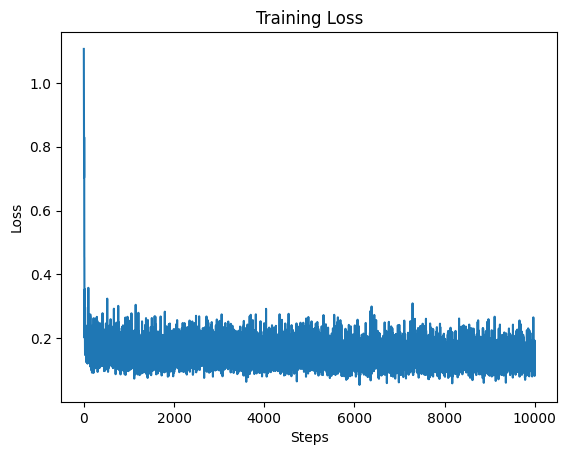

Sampling: 100%|██████████| 1000/1000 [01:54<00:00,  8.77it/s]


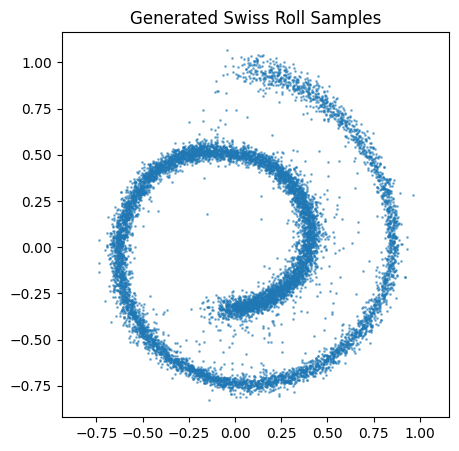

In [8]:
# Train the diffusion model
model, losses, scheduler, device = train_diffusion(n_steps=10000)

# Plot the training loss curve
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Generate samples using the trained model
try:
    samples = generate_samples(model, scheduler, n_samples=10000)
    visualize_samples(samples)
except NotImplementedError as e:
    print(e)

## Visualizing the Forward Diffusion Process

In the forward process, we gradually add noise to the data. In the visualization below, the data is shown at several key timesteps.  

**Steps explained:**
1. **Generate Initial Data:** We start with the clean Swiss Roll dataset.
2. **Select Timesteps:** We choose a few key timesteps (e.g., 0%, 2%, 5%, 10%, 20%, 50%, and 100% of the max timestep) to demonstrate the gradual corruption.
3. **Apply Diffusion:** For each selected timestep, we compute the noisy data using `scheduler.diffuse()`.
4. **Visualization:** A scatter plot of the noisy data is displayed for each timestep.

> **Hint:**  
> The diffusion function uses:  
 $$
 x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t}\,\epsilon
 $$
> where $\epsilon$ is standard Gaussian noise.  
> Check comments in the code for further guidance.


In [9]:
def visualize_forward_process(model, scheduler, n_samples=1000):
    """
    Visualize how data gets progressively noisier in the forward process.

    Args:
        model: The diffusion model (not directly used in forward process but kept for consistency).
        scheduler: The diffusion scheduler which supplies the noise schedule.
        n_samples: Number of data points to use for visualization.
    """
    # Get the device from model parameters.
    device = next(model.parameters()).device

    # Generate the initial clean Swiss Roll data.
    x_0 = generate_swiss_roll(n_samples).to(device)

    # Prepare a list of timesteps to visualize
    # Ensure timesteps do not exceed the scheduler's maximum value.
    max_timestep = scheduler.num_timesteps - 1
    plot_steps = [
        int(t) for t in [0, max_timestep * 0.02, max_timestep * 0.05,
                         max_timestep * 0.1,  max_timestep * 0.2,
                         max_timestep * 0.5, max_timestep]
    ]

    # Create a grid of subplots for each selected timestep.
    fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 3))

    # Loop over each selected timestep to compute and plot the corresponding noisy data.
    for idx, t in enumerate(plot_steps):
        # Create a tensor of timesteps of size equal to n_samples.
        timesteps = torch.full((n_samples,), t, device=device, dtype=torch.long)
        # Apply the forward diffusion process: add noise to the data.
        x_t, _ = scheduler.diffuse(x_0, timesteps)

        # Plot the noisy data.
        ax = axes[idx]
        samples = x_t.detach().cpu().numpy()  # Detach from graph and move data to CPU.
        ax.scatter(
            samples[:, 0], samples[:, 1],
            s=10, alpha=0.5, color=plt.cm.viridis(0.1 + 0.8 * idx / len(plot_steps))
        )
        ax.set_title(f't = {t}')  # Mark the current timestep on the plot.
        ax.set(xlim=(-2.3, 2.7), ylim=(-2.4, 2.6))
        ax.set_aspect('equal')
        ax.set(xticks=[], yticks=[])

    plt.suptitle('Forward Process: Data → Noise', y=1.05)
    plt.tight_layout()
    plt.show()

# You can call this function to visualize the forward process.
# visualize_forward_process(model, scheduler)

## Visualizing the Reverse Diffusion Process

In the reverse process, the model starts from pure noise and progressively denoises the data until a coherent structure (the Swiss Roll) is recovered.

**Steps explained:**
1. **Start from Noise:** Begin with pure noise as \( x_T \).
2. **Reverse Diffusion:** At each reverse step \( t \rightarrow t-1 \), apply the denoising step using `scheduler.reverse_step()`.
3. **Save Snapshots:** At selected timesteps, save the generated data to visualize the denoising trajectory.
4. **Visualization:** The plots show how the model’s output changes from random noise to structured data.

> **Hint:**  
> The reverse step is based on:  
$$
 x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \,\hat{\epsilon} \right) + \sqrt{\beta_t}\,\mathbf{z}
$$
> where $\mathbf{z}$ is Gaussian noise (only when $ t > 0 $)
>
> Ensure your `reverse_step` function implementation is correct before visualizing.


In [10]:
def visualize_reverse_process(model, scheduler, n_samples=1000):
    """
    Visualize the generation (reverse diffusion) process, showing the progressive denoising.

    Args:
        model: The diffusion model trained for denoising.
        scheduler: The scheduler that contains the reverse process implementation.
        n_samples: Number of samples to generate and visualize.
    """
    # Get the device from the model.
    device = next(model.parameters()).device

    # Start from pure noise.
    x = torch.randn(n_samples, 2).to(device)

    # Define selected timesteps to capture snapshots from the denoising process.
    max_timestep = scheduler.num_timesteps - 1
    plot_steps = [
        int(t) for t in [max_timestep, max_timestep * 0.5, max_timestep * 0.2,
                         max_timestep * 0.1, max_timestep * 0.05, max_timestep * 0.02, 0]
    ]
    # Dictionary to save samples at chosen timesteps.
    samples_to_save = {step: None for step in plot_steps}

    # Create subplots for visualization.
    fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 3))

    # Reverse diffusion process loop.
    with torch.no_grad():
        # Iterate from the last timestep backwards.
        for step in tqdm(range(scheduler.num_timesteps - 1, -1, -1), desc="Sampling"):
            # Create a tensor of the current timestep for all samples.
            t = torch.full((n_samples,), step, device=device, dtype=torch.long)
            # Predict the noise for the current step.
            predicted_noise = model(x, t.float() / scheduler.num_timesteps)
            # Apply the reverse step to obtain data from the previous timestep.
            x = scheduler.reverse_step(x, step, predicted_noise)

            # If the current step is a designated snapshot, save the current data.
            if step in plot_steps:
                idx = plot_steps.index(step)  # Identify subplot index.
                ax = axes[idx]
                samples = x.detach().cpu().numpy()  # Convert tensor for plotting.
                ax.scatter(
                    samples[:, 0], samples[:, 1],
                    s=10, alpha=0.5, color=plt.cm.magma(0.1 + 0.8 * idx / len(plot_steps))
                )
                ax.set_title(f't = {step}')
                ax.set(xlim=(-2.3, 2.7), ylim=(-2.4, 2.6))
                ax.set_aspect('equal')
                ax.set(xticks=[], yticks=[])

    plt.suptitle('Reverse Process: Noise → Data', y=1.05)
    plt.tight_layout()
    plt.show()

# You can call this function to visualize the reverse process.
# visualize_reverse_process(model, scheduler)


## Comparing Real and Generated Samples

In this final visualization, we compare the original Swiss Roll data with the data generated by the diffusion model.  
This side-by-side view offers insight into how effectively the diffusion model recovers the original data distribution.  

**Steps explained:**
- **Real Data:** We generate a fresh batch of Swiss Roll data.
- **Generated Data:** We use the trained diffusion model and the reverse process to produce data starting from noise.
- **Comparison:** Display both plots side-by-side for an intuitive visual comparison.


Sampling: 100%|██████████| 1000/1000 [00:07<00:00, 133.91it/s]


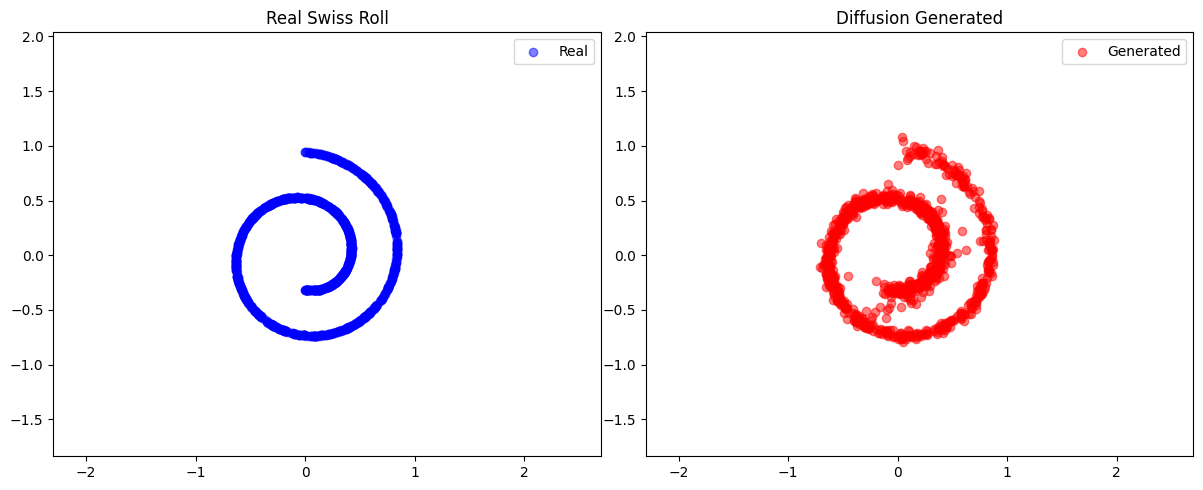

In [11]:
# Compare real and generated samples side-by-side.
plt.figure(figsize=(12, 5))

# Plot the original (real) Swiss Roll data.
plt.subplot(1, 2, 1)
real_data = generate_swiss_roll(1000)
plt.scatter(real_data[:, 0], real_data[:, 1],
            c='blue', alpha=0.5, label='Real')
plt.title('Real Swiss Roll')
plt.legend()
plt.axis('equal')
plt.xlim(-2.3, 2.7)
plt.ylim(-2.4, 2.6)

# Plot the diffusion-generated data.
plt.subplot(1, 2, 2)
# Ensure that your reverse_step function is implemented;
# otherwise, this might throw a NotImplementedError.
try:
    samples = generate_samples(model, scheduler)
    plt.scatter(samples[:, 0], samples[:, 1],
                c='red', alpha=0.5, label='Generated')
    plt.title('Diffusion Generated')
    plt.legend()
    plt.axis('equal')
    plt.xlim(-2.3, 2.7)
    plt.ylim(-2.4, 2.6)
except NotImplementedError as e:
    plt.text(0.5, 0.5, str(e), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title('Error in Generation Process')

plt.tight_layout()
plt.show()

## Final Notes

### Implement the reverse_step Function:
 - The reverse step function contains a placeholder NotImplementedError. Use the provided hints and formula to fill in the missing implementation.
   
### Documentation and Comments:
 - Use the inline comments and markdown explanations above to guide your implementation and understanding.
   
### Testing:
 - Test your implementation of each module independently before running the full training and sampling process.


Good luck, and make sure to reach out if you have any questions about the implementation details or the underlying theory!